# Практическая работа №1

# Классификация объектов с помощью свёрточных нейронных сетей.

## Выполнила: ИСУ - 472460, Сегень Р.А., группа R4135c

### Цели и задачи

Цель лабораторной работы: изучить процесс классификации объектов с помощью свёрточной нейронной сети на примере данных с kaggle.

### Задачи:

* Изучить библиотеки TensorFlow-Keras, torch-torchvision, NumPy и Matplotlib/Seaborn.

* Загрузить и предобработать данные.

* Разбить данные на обучающую и проверочную выборки.

* Определить архитектуру свёрточной нейронной сети (использовать предобученную архитектуру и архитектуру "с нуля".

* Обучить модели на обучающей выборке.

* Оценить качество моделей на проверочной выборке.

* Подобрать оптимальные гиперпараметры моделей на основе результатов на проверочной выборке.

* Протестировать модели на проверочной (тестовой) выборке.

* Оценить качество моделей на основе метрик.

* Построить графики, чтобы проанализировать процесс обучения и оценки качества моделей на обучающей, проверочной выборках.




# 1. Загрузка данных

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import models
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# загрузка данных из гугл диска
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

zip_path = "/content/drive/My Drive/veg.zip"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("/content/data")

os.listdir("/content/data") # показать содержимое


Mounted at /content/drive


['Vegetable Images']

In [4]:
# дата сет
import os

data_path = "/content/data/Vegetable Images"
train_data_dir = "/content/data/Vegetable Images/train"
test_data_dir = "/content/data/Vegetable Images/test"
val_data_dir = "/content/data/Vegetable Images/validation"


# посмотрим содержимое директорий
print(os.listdir(data_path))
print(os.listdir(train_data_dir))
print(os.listdir(test_data_dir))
print(os.listdir(val_data_dir))

['validation', 'test', 'train']
['Carrot', 'Cauliflower', 'Bottle_Gourd', 'Cabbage', 'Broccoli', 'Radish', 'Brinjal', 'Potato', 'Tomato', 'Cucumber', 'Papaya', 'Bean', 'Capsicum', 'Bitter_Gourd', 'Pumpkin']
['Carrot', 'Cauliflower', 'Bottle_Gourd', 'Cabbage', 'Broccoli', 'Radish', 'Brinjal', 'Potato', 'Tomato', 'Cucumber', 'Papaya', 'Bean', 'Capsicum', 'Bitter_Gourd', 'Pumpkin']
['Carrot', 'Cauliflower', 'Bottle_Gourd', 'Cabbage', 'Broccoli', 'Radish', 'Brinjal', 'Potato', 'Tomato', 'Cucumber', 'Papaya', 'Bean', 'Capsicum', 'Bitter_Gourd', 'Pumpkin']


In [ ]:
# #  скачаем торч
 !pip install torchvision


In [5]:
#  количество объектов в классах

def count_images(directory):

    categories = os.listdir(directory)

    category_count = {category: len(os.listdir(os.path.join(directory, category))) for category in categories}
    return category_count




train_count = count_images(train_data_dir)
test_count = count_images(test_data_dir)
validation_count = count_images(val_data_dir)



print(f"Train sample count : {train_count}\n")
print(f"Test sample count : {test_count}\n")
print(f"Validation sample count : {validation_count}")

Train sample count : {'Carrot': 1000, 'Cauliflower': 1000, 'Bottle_Gourd': 1000, 'Cabbage': 1000, 'Broccoli': 1000, 'Radish': 1000, 'Brinjal': 1000, 'Potato': 1000, 'Tomato': 1000, 'Cucumber': 1000, 'Papaya': 1000, 'Bean': 1000, 'Capsicum': 1000, 'Bitter_Gourd': 1000, 'Pumpkin': 1000}

Test sample count : {'Carrot': 200, 'Cauliflower': 200, 'Bottle_Gourd': 200, 'Cabbage': 200, 'Broccoli': 200, 'Radish': 200, 'Brinjal': 200, 'Potato': 200, 'Tomato': 200, 'Cucumber': 200, 'Papaya': 200, 'Bean': 200, 'Capsicum': 200, 'Bitter_Gourd': 200, 'Pumpkin': 200}

Validation sample count : {'Carrot': 200, 'Cauliflower': 200, 'Bottle_Gourd': 200, 'Cabbage': 200, 'Broccoli': 200, 'Radish': 200, 'Brinjal': 200, 'Potato': 200, 'Tomato': 200, 'Cucumber': 200, 'Papaya': 200, 'Bean': 200, 'Capsicum': 200, 'Bitter_Gourd': 200, 'Pumpkin': 200}


Преобразуем данные к 224х224 пикселя с помощью `transforms.Compose`. Для загрузки данных в предобученную модель (Resnet18), используем `ImageDataLoader`.
Этот класс загружает данные из датасета батчами, используется для итерации по данным во время обучения (каждая итерация соответствует загрузке одного батча данных).

In [6]:
# загрузим библиотеки из торч
import torchvision.datasets as datasets
from torchvision import datasets
from torchvision.datasets import ImageFolder

# Преобразуем данные к 224х224
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])


# Создадим датасеты
train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
val_dataset = ImageFolder(val_data_dir, transform=val_transforms)
test_dataset = ImageFolder(test_data_dir, transform=test_transforms)

# Загрузка данных из датасета батчами
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Отобразим случайную выборку из тренировочных данных.

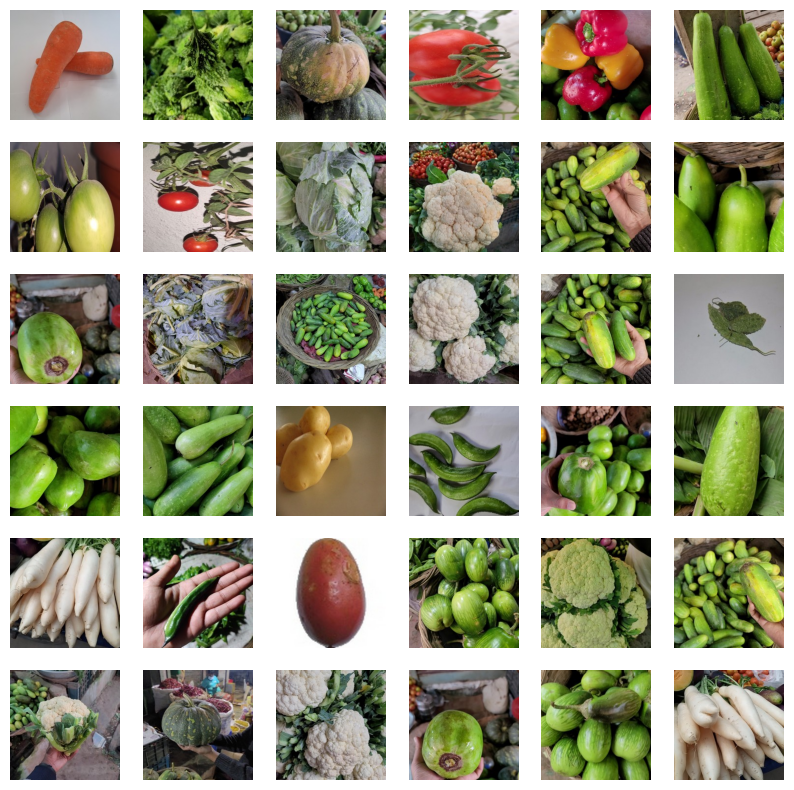

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def show_random_images(images, num_images=36):
    # Выбор случайных индексов для отображения изображений
    indices = random.sample(range(len(images)), min(num_images, len(images)))

    images = images.numpy().transpose((0, 2, 3, 1))

    fig, axes = plt.subplots(6, 6, figsize=(10, 10))

    for i in range(num_images):
        ax = axes[i // 6][i % 6] if num_images > i else None

        if ax is not None:
            ax.imshow(images[indices[i]])
            ax.axis('off')

        else:
            break

    plt.show()

# Получение первого батча из тренировочного загрузчика данных
images_batch = next(iter(train_loader))[0]

# Отображение случайных изображений из батча без нормализации цветов
show_random_images(images_batch)




In [ ]:
#  набор классов в выборке
train_classes_list = train_dataset.classes
val_classes_list = val_dataset.classes
test_classes_list = test_dataset.classes
print(f"список классов в тренировочной выборке: {train_classes_list}")
print(f"список классов в валидационной выборке: {val_classes_list}")
print(f"список классов в тестовой выборке: {test_classes_list}")


список классов в тренировочной выборке: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
список классов в валидационной выборке: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
список классов в тестовой выборке: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


Проверим количество батче в выборках.

In [ ]:
len(train_loader), len(val_loader), len(test_loader) # количество батчей в даталодер
print("train", len(train_loader))
print("test", len(test_loader))
print("val", len(val_loader))


train 235
test 47
val 47


# 2. Создание новой нейронной сети с  нуля.

## 2.1 Преобразование данных.


Для новой нейросети с нуля я решила использовать библиотеку `TensorFlow`, модуль `Keras`. С помощью `ImageDataGenetaror` преобразуем  значения пикселей изображений к диапазону от 0 до 1, а также изменим размер изображений на 224х224. Количество батчей установим 32. Для многоклассовой классификации (как у нас) определим режим `categorical`.

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Создание генератора данных для тренировочной выборки
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: tf.image.resize(x, (224, 224)))

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Создание генератора данных для валидационной выборки
val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)



Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [9]:
classes = train_generator.class_indices
classes

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

## 2.2 Создание модели

Для создания новой нейросети, воспользуемся информацией на официальном сайте TesorFlow [последовательная модель Sequential ](https://www.tensorflow.org/guide/keras/sequential_model?hl=ru). Последовательная модель `Sequential` состоит из стека слоев, где каждый слой имеет ровно один тензор входной и один выходной тензор. В качестве функций активации на скрытых слоях применяется нелинейная функция ReLu, на вызодном слое SoftMax.

In [13]:
from tensorflow.keras import layers, models

num_classes = 15

model = models.Sequential([
    # Первый скрытый слой 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # 32 фильтра
    layers.MaxPooling2D((2, 2)),

    # Второй скрытый слой 2
    layers.Conv2D(64, (3, 3), activation='relu'),  # 64 фильтра
    layers.MaxPooling2D((2, 2)),

    # Выравнивание данных для полносвязных слоев
    layers.Flatten(),

    # Выходной слой
    layers.Dense(num_classes, activation='softmax')  # Выходной слой
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │       2,799,375 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,818,767 (10.75 MB)

 Trainable params: 2,818,767 (10.75 MB)

 Non-trainable params: 0 (0.00 B)

## 2.3 Обучение с помощью метода `model.fit()`

Для обучения модели используется метод . Количество эпох выбрано 5.

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 73s 144ms/step - accuracy: 0.5303 - loss: 1.7789 - val_accuracy: 0.8333 - val_loss: 0.5585
Epoch 2/5
  1/468 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.9062 - loss: 0.3266

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9062 - loss: 0.3266 - val_accuracy: 0.8427 - val_loss: 0.5443
Epoch 3/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 71s 152ms/step - accuracy: 0.9139 - loss: 0.2881 - val_accuracy: 0.8989 - val_loss: 0.3520
Epoch 4/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9688 - loss: 0.1253 - val_accuracy: 0.9002 - val_loss: 0.3589
Epoch 5/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 69s 146ms/step - accuracy: 0.9673 - loss: 0.1170 - val_accuracy: 0.9120 - val_loss: 0.3392


In [16]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy:.3f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9196 - loss: 0.3290
Validation Accuracy: 0.912


Точность на валидационной выборке составляет 91,2%

После визуализируем данные с помощью графиков. Будут показаны точность модели на тренировочной и валидационной выборках, а также функция потерь на тех же выборках.

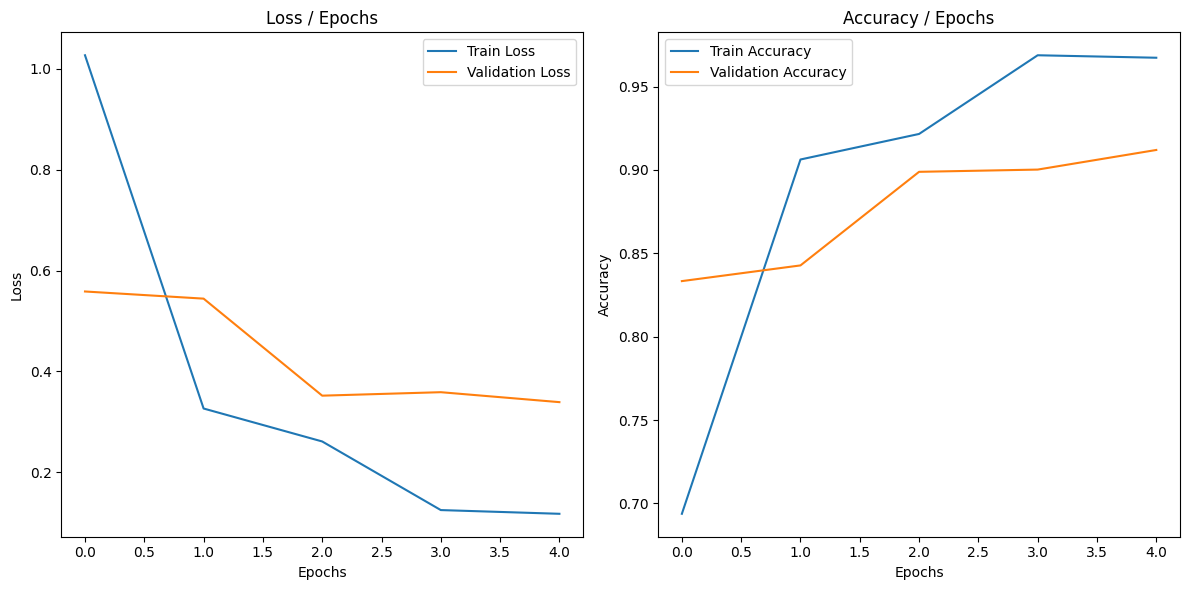

In [17]:
import matplotlib.pyplot as plt

# Извлечение данных из history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# # Оценка модели на тестовых данных
# test_loss, test_accuracy = model.evaluate(test_gen)
# print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')

# График функции потерь (Loss)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss / Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy / Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

По графикам можно сделать вывод что модель переобучилась. Это видно по графику точности на тренировочном датасете, он стремится к 1.0, что означает, что модель "заучила" данные. А нам необходимо, чтобы модель обучилась на признаках. Есть несколько решений: доабвить аугментацию, dropout.
Я добавлю dropout.


In [18]:
from tensorflow.keras import layers, models

model_2 = models.Sequential([
    # Первый скрытый слой 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    # Второй скрытый слой 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Выравнивание данных
    layers.Flatten(),


    layers.Dropout(0.2),  # Dropout
    layers.Dense(num_classes, activation='softmax')  # Выходной слой
])

model_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │       2,799,375 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,818,767 (10.75 MB)

 Trainable params: 2,818,767 (10.75 MB)

 Non-trainable params: 0 (0.00 B)

Также проводим обучение второй модели.

In [19]:
history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // validation_generator.batch_size
)

Epoch 1/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 73s 152ms/step - accuracy: 0.5546 - loss: 1.7745 - val_accuracy: 0.8468 - val_loss: 0.5178
Epoch 2/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8438 - loss: 0.3103 - val_accuracy: 0.8569 - val_loss: 0.4840
Epoch 3/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 73s 156ms/step - accuracy: 0.9129 - loss: 0.3000 - val_accuracy: 0.8985 - val_loss: 0.3639
Epoch 4/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9062 - loss: 0.2788 - val_accuracy: 0.8911 - val_loss: 0.3818
Epoch 5/5
468/468 ━━━━━━━━━━━━━━━━━━━━ 83s 177ms/step - accuracy: 0.9681 - loss: 0.1206 - val_accuracy: 0.8931 - val_loss: 0.3834


Далее я визуализировала данные уже с примененным `Dropout`.

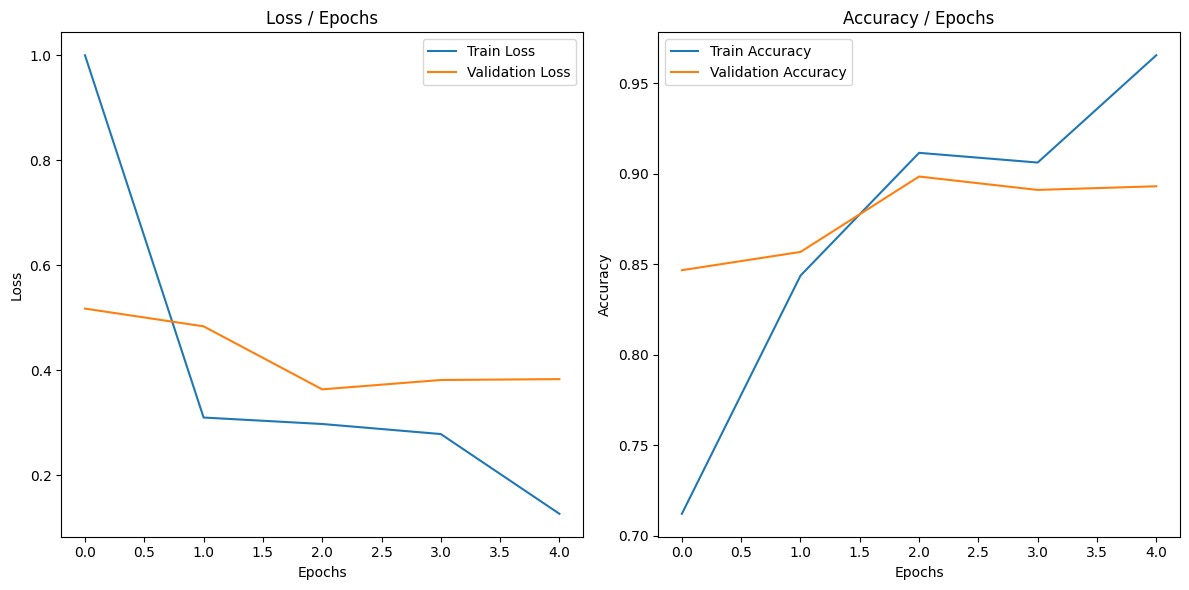

In [20]:
import matplotlib.pyplot as plt

# Извлечение данных из history
train_loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

train_accuracy_2 = history_2.history['accuracy']
val_accuracy_2 = history_2.history['val_accuracy']

# График функции потерь (Loss)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_2, label='Train Loss')
plt.plot(val_loss_2, label='Validation Loss')
# plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.title('Loss / Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_2, label='Train Accuracy')
plt.plot(val_accuracy_2, label='Validation Accuracy')
# plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
plt.title('Accuracy / Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Видим, что точность модели немного упала, но она увеличивается постепенно а это значит, что модель научилась распознавать и классифицировать объекты по признакам.

## 2.4 Проверка на тестовой выборке.
Сначала преобразуем тестовые данные для оценки.

In [21]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_gen = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3000 images belonging to 15 classes.


Далее используем `evaluate()` используется для оценки модели тестовых данных (которые не показывались модели). В ответе мы получим значение точности `accuracy` и функции потерь `loss`.

In [22]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'\nTest Loss: {test_loss : .3f}, Test Accuracy: {test_accuracy : .3f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9115 - loss: 0.2989

Test Loss:  0.312, Test Accuracy:  0.910


График на тестовой выборке отображается как константа, так как при обучении модели тестовые данные не используются. Также на графике на тренировочной выборке, что модель как будто бы переобучилась. Можем добавить Dropout.

Точность модели на тестовой выборке составляет 91 %, что гвоорит о хорошем обучении модели.

# 3. Обучение нейросети на предобученой архитектуре.


## 3.1 Архетектура ResNet18.
Загрузим предобученную модель ResNet18 и заменим в ней последний слой так, чтобы на выходе было 15 классов. Gростая архитектура, подходит для задач классификации изображений.

In [26]:
!pip install keras-resnet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20452 sha256=bb3ff1e2a1b39c683a11a994cbbd7d4570b5294addf90f845ed42c6b82bafa69
  Stored in directory: /root/.cache/pip/wheels/41/e7/70/126fc8672253456753411e23c230d50c415f2fd6683b195869
Successfully built keras-resnet


In [30]:
import torch
import torchvision.models as models
import torch.nn as nn
from keras_resnet import models as resnet_models


# загрузим предобученую архитектуру модели ResNet18
model = models.resnet18(pretrained=True)

# заменим последний слой (на выходе 15 классов)
num_classes = 15
model.fc = nn.Linear(model.fc.in_features, num_classes)

# переместим модель на устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


## 3.2 Обучение сети.
Обучение нейронной сети на тренировочной выборке и на валидационной (проверочной) выборке.
количество эпох выбрано 3.
оптимизатор Adam.


In [53]:
# обучение сети
from tqdm import tqdm

# Определим функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# число эпох
num_epochs = 3

train_data_loss = []
train_data_accuracy = []
val_data_loss = []
val_data_accuracy= []

model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_data_loss.append(train_loss)
    train_data_accuracy.append(train_accuracy)

    # Валидация модели
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_data_loss.append(val_loss)
    val_data_accuracy.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Сохранение последней актуальной модели
    torch.save(model.state_dict(), 'last_model.pth')
    print()

print('Finish!')

100%|██████████| 47/47 [00:10<00:00,  4.36it/s]


Epoch [1/3], Train Loss: 0.0179, Train Accuracy: 0.9954, Val Loss: 0.0502, Val Accuracy: 0.9920



100%|██████████| 47/47 [00:09<00:00,  5.16it/s]


Epoch [2/3], Train Loss: 0.0187, Train Accuracy: 0.9949, Val Loss: 0.0221, Val Accuracy: 0.9947



100%|██████████| 47/47 [00:08<00:00,  5.30it/s]


Epoch [3/3], Train Loss: 0.0099, Train Accuracy: 0.9973, Val Loss: 0.0088, Val Accuracy: 0.9977

Finish!


## 3.3 Оценка модели на тестовой выборке
Прогон через тестовую выборку

Режим оценки. Метод `model.eval()` переводит модель в режим оценки (то етсь отключает возможный Dropout и Batch Normalization). Вычисляет предсказания модели, cчитает потери и точность на тестовой выборке

In [55]:
import torch
from tqdm import tqdm

# загрузим последнюю модель
model.load_state_dict(torch.load('last_model.pth'))
model.to(device)  # Переместите модель на устройство (GPU/CPU)

# Переводим модель в режим оценки
model.eval()

# Переменные для подсчета потерь и точности
test_loss = 0.0
correct = 0
total = 0

# Отключаем вычисление градиентов для ускорения и экономии памяти
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Перемещаем данные на устройство (GPU/CPU)
        images, labels = images.to(device), labels.to(device)

        # Прямой проход (forward pass)
        outputs = model(images)

        # Вычисление потерь
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Вычисление точности
        _, predicted = outputs.max(1)  # Получаем предсказанные классы
        total += labels.size(0)  # Общее количество примеров
        correct += predicted.eq(labels).sum().item()  # Количество правильных предсказаний

# Средние потери и точность на тестовых данных
test_loss /= len(test_loader)  # Средние потери
test_accuracy = correct / total  # Точность

# Вывод результатов
print(f'\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

<ipython-input-55-0f6e872b71c7>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('last_model.pth'))  # Загрузите лучшую модель
100%|████████


Test Loss: 0.0146, Test Accuracy: 0.9947


В результате мы получили 99%, что довольно очень высокая точность.

# 4. Выводы
В данной практической работе были изучены TensorFlow и PyTorch. Произведено обучение на преобученной архитектуре ResNet18 и архитектуре с нуля. На предобученной получены очень высокие данные по точности, по сравнению с архитектурой с нуля.
При обучении нейросети с нуля был добавлен метод регуляризации Dropout, который предотвращает переобучение (заучивание) нейросети данные.
